In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe
import bmi_cfe_statevars

import bmi_cfe_peturb
sys.path.insert(0, './Assimilation')
import Bmi_da_ENKF_forSBMI

#sys.path.append('/home/jovyan/data/NextGen---The-Simulators-/USGS/USGS_BMI_FT/cleaned_FT')
sys.path.append('C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT')

import bmi_usgs

In [2]:
print(bmi_cfe)
print(bmi_cfe_statevars)
print(bmi_cfe_peturb)

#print(Bmi_da_ENKF_forSBMI)
#print(bmi_usgs)


<module 'bmi_cfe' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe.py'>
<module 'bmi_cfe_statevars' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_statevars.py'>
<module 'bmi_cfe_peturb' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe_peturb.py'>


In [3]:
## Open BMI's for each file
cfe_open = bmi_cfe.BMI_CFE()
cfe_peturbed = bmi_cfe_peturb.BMI_CFE()
cfe_analysis = bmi_cfe_statevars.BMI_CFE() #true model in the end with updated state vars
enkf = Bmi_da_ENKF_forSBMI.EnKF_wrap()
usgs = bmi_usgs.BMI_USGS()

In [4]:
## Initialize the BMI's
# cfe_open.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
# cfe_peturbed.initialize(cfg_file='./CFE/cat_58_config_cfe_peturb_model.json')
# cfe_analysis.initialize(cfg_file='./CFE/cat_58_config_cfe.json') # I am confused what this config file should look like

# ## Case study files
cfe_open.initialize(cfg_file='./CFE/config_cfe_CT.json')
cfe_peturbed.initialize(cfg_file='./CFE/config_cfe_peturb_model_CT.json')
cfe_analysis.initialize(cfg_file='./CFE/config_cfe_CT.json')

enkf.initialize(cfg_file='./Assimilation/EnKF_config.json') # Need to create this still
usgs.initialize(cfg_file='C:/Users/zjbut/Documents/GitHub/NextGen---The-Simulators-/USGS/USGS_BMI_FT/usgs_config.json')



700
1
                         Date    Flow  validity
0   2015-05-01 04:00:00+00:00  2.0700       1.0
1   2015-05-01 05:00:00+00:00  2.0700       1.0
2   2015-05-01 06:00:00+00:00  2.0675       1.0
3   2015-05-01 07:00:00+00:00  2.0675       1.0
4   2015-05-01 08:00:00+00:00  2.0650       1.0
..                        ...     ...       ...
739 2015-05-31 23:00:00+00:00  1.7650       1.0
740 2015-06-01 00:00:00+00:00  1.9475       1.0
741 2015-06-01 01:00:00+00:00  2.0250       1.0
742 2015-06-01 02:00:00+00:00  2.0700       1.0
743 2015-06-01 03:00:00+00:00  2.1475       1.0

[744 rows x 3 columns]
USGS station ID 01123000


                time  APCP_surface  RAINRATE      T2D       Q2D     U2D  \
0      5/1/2007 0:00      0.000000  0.000000  287.524  0.005954  6.8022   
1      5/1/2007 1:00      0.000000  0.000000  286.360  0.005718  5.9674   
2      5/1/2007 2:00      0.000000  0.000000  285.190  0.005476  5.1368   
3      5/1/2007 3:00      0.000000  0.000000  284.028  0.005236  4.3022   
4      5/1/2007 4:00      0.000000  0.000000  283.386  0.005224  4.1124   
..               ...           ...       ...      ...       ...     ...   
739  5/31/2007 19:00      0.000000  0.000000  298.876  0.015622 -3.0062   
740  5/31/2007 20:00      0.000000  0.000000  298.920  0.015804 -2.9102   
741  5/31/2007 21:00      0.000000  0.000000  298.962  0.015976 -2.8106   
742  5/31/2007 22:00      0.000000  0.000000  296.786  0.014962 -2.7040   
743  5/31/2007 23:00      0.101904  0.000102  294.600  0.013988 -2.6036   

        V2D       PSFC   SWDOWN   LWDOWN  
0   -5.9622   98865.18    0.000  268.284  
1   -5.5988  

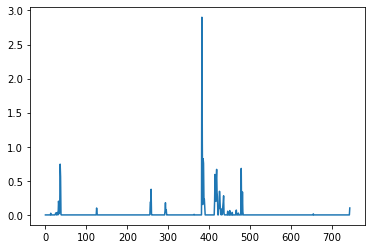

In [5]:
with open(cfe_open.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)
plt.plot(df_forcing['APCP_surface'])

In [6]:
# Make empty matrices for plotting
cfeOpen = []
cfePeturbed = []
#sim = []
#obs = []
#assimilation = []

## Loop through time. Set values for each model and get values
for i, precip in enumerate(df_forcing['APCP_surface']): #i is RAINRATE
## Case Study
#for i, precip in enumerate(df_forcing['RAINRATE']):
    
    # Set values for each model
    cfe_open.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_peturbed.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    cfe_analysis.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip)
    
    # Update usgs data and get value to put into EnKF
    usgs.update()
    obs = np.array(usgs.get_value('Flow')) #need array for EnKf function. should get this when initialize.  
    
    # Update CFE open and peturbed. Get value for peturbed stats. 
    cfe_open.update()
    cfe_peturbed.update()   
    
    # Get values for plotting
    outflow = cfe_open.get_value('land_surface_water__runoff_depth')
    cfeOpen.append(outflow) #for plotting
    outflow_peturb = cfe_peturbed.get_value('land_surface_water__runoff_depth_ens')
    
    # Get mean and covariance for stats of ensemble runs for EnKF
    outflow_peturb_mean = np.mean(outflow_peturb)
    outflow_peturb_covar = np.cov(outflow_peturb)
    cfePeturbed.append(outflow_peturb_mean) #for plotting
    
    # Set EnKF value to usgs, mean, and covariance. Get value from it then
    enkf.set_value('x', outflow_peturb_mean)
    enkf.set_value('P', outflow_peturb_covar)
    enkf.set_value('z', obs)

    state_transition = enkf.get_value('factor') #getting factor to change
    # factor is based on EnKF/simulation. % change from assimilation to CFE
    
    # want to get factor from lookup table
    
    # Set value for CFE analysis based on the state variable change from the EnKF factor tog et true streamflow
    cfe_analysis.set_value('state_var_change_runoff', state_transition) #look up value from lookup table based on EnKF factor   
    cfe_analysis.update() #get new streamflow value based on state var change
    
    # Set state variable change of the peturbed model 
    #cfe_perturbed.set_value('state_var_change_runoff', state_transition)
    #cfe_perturbed.get_value('land_surface_water__runoff_depth_ens')
    #cfe_perturbed.update()
        
    # Update final model from value of analysis
    cfe_updated_everything = cfe_analysis.get_value('runoff_queue_m_per_timestep')
    cfe_perturbed.set_value('runoff_queue_m_per_timestep', cfe_updated_everything)
   
    
# Finalize models
cfe_open.finalize(print_mass_balance=True)
cfe_peturbed.finalize(print_mass_balance=True)
cfe_analysis.finalize(print_mass_balance=True)
usgs.finalize()
enkf.finalize()

KeyError: 'factor'

In [ ]:
istart_plot=500
iend_plot=720
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.title('Sub-Region Model DA Example')
plt.plot(x, cfePeturbed[istart_plot:iend_plot], color = 'tab:blue', label = 'CFE Peturbed')
plt.plot(x, cfeOpen[istart_plot:iend_plot], color = 'green', label = 'CFE Open')
plt.plot(x, obs[istart_plot:iend_plot]*10, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


In [ ]:
# cfe_open = bmi_cfe()
# cfe_perturbed = bmi_cfe()
# cfe_analysis = bmi_cfe()
# enkf = bmi_enkf()
# usgs = bmi_usgs()

# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

# For time in daterange():
#     forcing = forcings[time]
#     cfe_open.set_value(forcing)
#     cfe_perturbed.set_value(forcing)
#     cfe_analysis.set_value(forcing)
#     usgs.update()
#     obs = usgs.get_value()

#     cfe_open.update()
#     cfe_perturbed.update()
#     mean, variance  = cfe_perturbed.get_value()

#     enkf.set_value(obs, mean, variance )

#     state_transition = enkf.get_value()

#     cfe_analysis.set_value(state_transition)
#     cfe_analysis.update()

#     cfe_perturbed.set_value(state_transition)
#     

#     cfe_updated_everything = cfe_analysis.get_value(everything)
#     cfe_perturbed.set_value(cfe_updated_everything)



# cfe_open.initialize(‘config_open.yml’)
# cfe_perturbed.initialize(‘config_perturbed.yml’)
# cfe_analysis.initialize(‘config_analysis.yml’)
# enkf.initialize(‘config_enkf_cfe_basinID.yml’)
# usgs.initialize(‘config_basinID.yml’)

